xFormers not available
xFormers not available


Using device: cuda
Model vitb loaded!


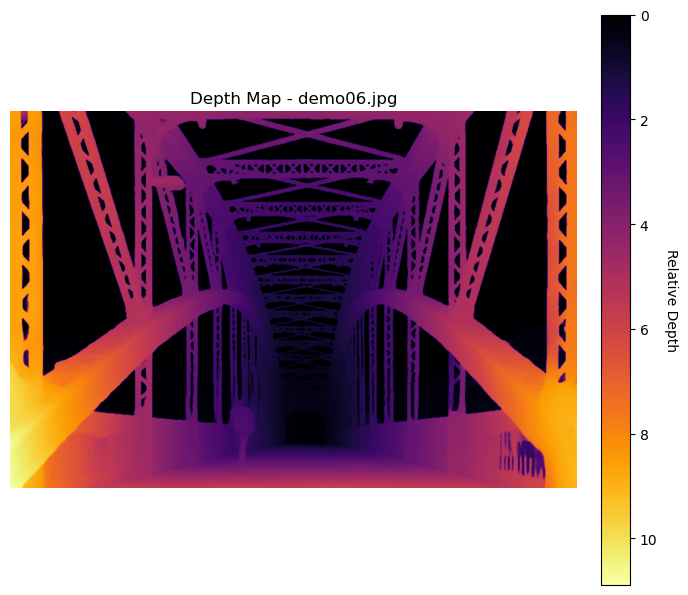

In [1]:
import cv2
import torch
import matplotlib.pyplot as plt
from depth_anything_v2.dpt import DepthAnythingV2
import os

# -------------------------------
# 1️⃣ Configurer le device
# -------------------------------
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", DEVICE)

# -------------------------------
# 2️⃣ Configurer le modèle
# -------------------------------
model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

encoder = 'vitb'  # plus léger que vitl pour tester facilement

# Charger le modèle
model = DepthAnythingV2(**model_configs[encoder])
model_path = f'checkpoints/depth_anything_v2_{encoder}.pth'
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model = model.to(DEVICE).eval()
print(f"Model {encoder} loaded!")


# -------------------------------
# 3️⃣ Choisir le numéro de l'image
# -------------------------------
num = int(input("Entrez le numéro de l'image (1 à 20) : "))
img_filename = f"demo{num:02d}.jpg"

folder_path = r'C:\Users\ZEJLI\Desktop\Transformers\Depth-Anything-V2\assets\examples'
img_path = os.path.join(folder_path, img_filename)

# Charger l'image
raw_img = cv2.imread(img_path)
if raw_img is None:
    raise FileNotFoundError(f"Image not found at {img_path}")

# Convertir BGR -> RGB
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

# -------------------------------
# 4️⃣ Prédire la carte de profondeur
# -------------------------------
with torch.no_grad():
    depth = model.infer_image(raw_img)

# -------------------------------
# 5️⃣ Afficher la profondeur avec échelle
# -------------------------------
plt.figure(figsize=(8, 8))
im = plt.imshow(depth, cmap='inferno')
plt.axis('off')
plt.title(f"Depth Map - {img_filename}")

cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Relative Depth', rotation=270, labelpad=15)
cbar.ax.invert_yaxis()  # optionnel : clair=proche, foncé=loin

plt.show()


# 🌈 Légende de la carte de profondeur

Les cartes de profondeur générées utilisent la **palette de couleurs `inferno`** : du violet foncé au jaune/blanc.  

- **Couleur violette / sombre** → **Objets éloignés**  
- **Couleur orange / jaune / blanche** → **Objets proches**  

En résumé :  

| Couleur          | Signification                   |
|-----------------|--------------------------------|
| Violet / noir   | Loin (grande distance)         |
| Rouge / orange  | Distance intermédiaire         |
| Jaune / blanc   | Proche (petite distance)      |

💡 **Astuce** : La barre de couleur affichée à côté de la carte de profondeur permet de comparer rapidement les distances relatives dans l’image.  

**Exemple visuel :**  



Device set to use cuda:0


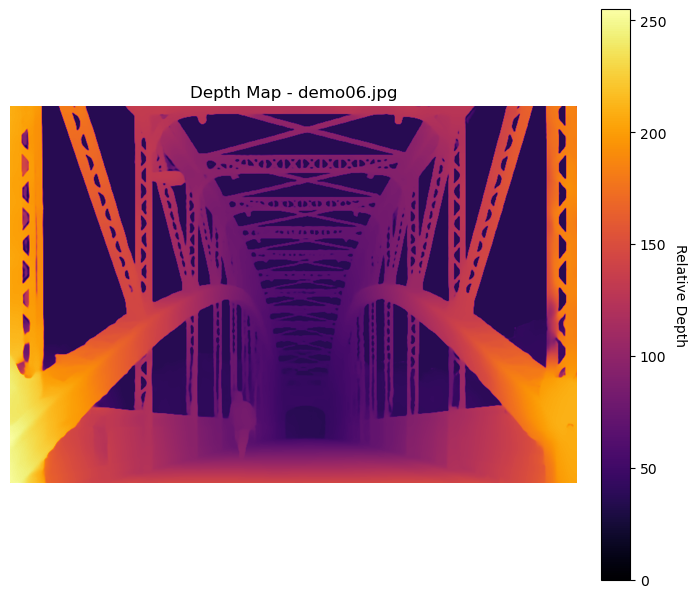

In [3]:
from transformers import pipeline
from PIL import Image
import matplotlib.pyplot as plt
import os

# -------------------------------
# 1️⃣ Configurer le pipeline Transformers
# -------------------------------
pipe = pipeline(
    task="depth-estimation", 
    model="depth-anything/Depth-Anything-V2-Small-hf",
    device=0,       # GPU
    use_fast=True   # utilise le processeur rapide
)

# -------------------------------
# 2️⃣ Choisir l'image à traiter
# -------------------------------
folder_path = r'C:\Users\ZEJLI\Desktop\Transformers\Depth-Anything-V2\assets\examples'

# Demander à l'utilisateur quel numéro d'image il veut afficher
num = int(input("Entrez le numéro de l'image (1 à 20) : "))
img_filename = f"demo{num:02d}.jpg"
img_path = os.path.join(folder_path, img_filename)

# -------------------------------
# 3️⃣ Charger l'image
# -------------------------------
image = Image.open(img_path)

# -------------------------------
# 4️⃣ Prédire la profondeur
# -------------------------------
depth = pipe(image)["depth"]  # HxW numpy array

# -------------------------------
# 5️⃣ Afficher la carte de profondeur avec barre de couleur
# -------------------------------
plt.figure(figsize=(8, 8))
im = plt.imshow(depth, cmap='inferno') 
plt.axis('off')
plt.title(f"Depth Map - {img_filename}")

cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Relative Depth', rotation=270, labelpad=15)

plt.show()


## Différence entre modèle local et pipeline Hugging Face pour Depth Anything V2

- **Modèle local avec OpenCV :**  
  - Chargé via PyTorch avec checkpoint local.  
  - Prétraitement des images avec OpenCV.  
  - Contrôle complet sur le modèle, mais upsampling légèrement différent → prédictions peuvent varier.

- **Pipeline Hugging Face avec Pillow :**  
  - Chargé automatiquement depuis le Hub HF.  
  - Prétraitement des images avec Pillow (`use_fast=True` pour un processor rapide).  
  - Prédictions plus cohérentes et recommandées pour un usage standard.

**Conclusion :**  
Les différences principales viennent du prétraitement et de l’upsampling. Pour la majorité des usages, le pipeline Hugging Face est conseillé pour sa simplicité et sa stabilité, tandis que le modèle local est utile pour le fine-tuning ou le contrôle des checkpoints.
